In [16]:
from scipy import signal
import cv2
import sys
import pandas as pd
import imhandle as imh
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import os
import xlrd 
import math
from pylab import*
from scipy import signal
import numpy as np
from matplotlib import pyplot as plt
from skimage.feature import greycomatrix, greycoprops
from skimage import data
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(10,10))

In [17]:
#IMPORT GROUND TRUTH
wb = xlrd.open_workbook("E:\optic-cup-disc/Drishti-GS1_diagnosis.xlsx") 
sheet = wb.sheet_by_index(0) 
val = [sheet.col_values(1)[5:],sheet.col_values(8)[5:]]

In [18]:
#DATA EXTRACTION FUNCTION

def extract_DRISHTI_GS_train(db_folder,cdr,train_data):

    disc_all, cup_all, file_codes_all,exp1,exp2,exp3,avg = [], [], [], [], [], [], []
    if train_data:
        set_path = os.path.join(db_folder, 'Drishti-GS1_files','Drishti-GS1_files', 'Training')
    else:
        set_path = os.path.join(db_folder, 'Drishti-GS1_files','Drishti-GS1_files', 'Test')
    images_path = os.path.join(set_path, 'Images')
    X_all, file_names = imh.load_set(images_path)
    rel_file_names = [os.path.split(fn)[-1] for fn in file_names]
    rel_file_names_wo_ext = [fn[:fn.rfind('.')] for fn in rel_file_names]
    if train_data:
        file_codes = ['Training' + fn[fn.find('_'):] for fn in rel_file_names_wo_ext]
    else:
        file_codes = [fn[fn.find('_'):] for fn in rel_file_names_wo_ext]
    file_codes_all.extend(file_codes)
    
    for fn in rel_file_names_wo_ext:
        if cdr:
            if train_data:
                CDR = open(os.path.join(set_path, 'GT', fn,fn + '_cdrValues.txt'),'r')
            else:
                CDR = open(os.path.join(set_path, 'Test_GT', fn,fn + '_cdrValues.txt'),'r')
            CDR = list(CDR)
            CDR = CDR[0].split()
            exp1.append(CDR[0])
            exp2.append(CDR[1])
            exp3.append(CDR[2])
            avg.append(CDR[3])
            
    return X_all, file_codes_all,exp1,exp2,exp3,avg,file_names

In [19]:
# GET DATA

X_all,file_codes_all,exp1,exp2,exp3,avg,file_names = extract_DRISHTI_GS_train('E:\optic-cup-disc',True,False)

In [20]:
# FUNCTION TO SEGMENT CUP AND DISK

def segment(image,plot_seg,plot_hist):
    image = image[400:1400,500:1600,:]
    #----------------------------PRE-PROCESSING AND SMOOTHING---------------------------------

    Abo,Ago,Aro = cv2.split(image)  #splitting into 3 channels
    #clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(9,9))
    #Aro = clahe.apply(Aro)
    Ago = clahe.apply(Ago)
    M = 60
    filter = signal.gaussian(M, std=6) #Gaussian Window
    filter=filter/sum(filter)
    STDf = filter.std()
    
    #glcm = greycomatrix(Aro, [3], [0])
    #stats = greycoprops(glcm)
    #par1 = stats(1,1)
    #clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    Ar = Aro - Aro.mean() - Aro.std() #Preprocessing Red
    
    Mr = Ar.mean()                           #Mean of preprocessed red
    SDr = Ar.std()                           #SD of preprocessed red
    Thr = 0.5*M - STDf - Ar.std()              #OD Threshold
    #Thr = Ar.std()
    #print(Thr)

    Ag = Ago - Ago.mean() - Ago.std() #Preprocessing Green
    Mg = Ag.mean()                           #Mean of preprocessed green
    SDg = Ag.std()                           #SD of preprocessed green
    Thg = 0.5*Mg +2*STDf + 2*SDg + Mg        #OC Threshold
    #print(Thg)
    
    
    hist,bins = np.histogram(Ag.ravel(),256,[0,256])   #Histogram of preprocessed green channel
    histr,binsr = np.histogram(Ar.ravel(),256,[0,256]) #Histogram of preprocessed red channel


    #smooth_hist_g,bins = np.histogram(Ag.flatten(),256,[0,256])
    #smooth_hist_g,binsr = np.histogram(Ar.flatten(),256,[0,256])
    smooth_hist_g=np.convolve(filter,hist)  #Histogram Smoothing Green
    smooth_hist_r=np.convolve(filter,histr) #Histogram Smoothing Red
    
    if plot_hist:
        plt.subplot(2, 2, 1)
        plt.plot(hist)
        plt.title("Preprocessed Green Channel")

        plt.subplot(2, 2, 2)
        plt.plot(smooth_hist_g)
        plt.title("Smoothed Histogram Green Channel")

        plt.subplot(2, 2, 3)
        plt.plot(histr)
        plt.title("Preprocessed Red Channel")

        plt.subplot(2, 2, 4)
        plt.plot(smooth_hist_r)
        plt.title("Smoothed Histogram Red Channel")

        plt.show()
    
    r,c = Ag.shape
    Dd = np.zeros(shape=(r,c))
    Dc = np.zeros(shape=(r,c))

    #plt.imshow(equ)
    for i in range(1,r):
        for j in range(1,c):
            if Ar[i,j]>Thr:
                Dd[i,j]=255
            else:
                Dd[i,j]=0

    for i in range(1,r):
        for j in range(1,c):
        
            if Ag[i,j]>Thg:
                Dc[i,j]=1
            else:
                Dc[i,j]=0
                
    cv2.imwrite('disk.png',Dd)
    plt.imsave('cup.png',Dc)
    
    if plot_seg:
        plt.imshow(Dd, cmap = 'gray', interpolation = 'bicubic')
        plt.axis("off")
        plt.title("Optic Disk")
        plt.show()
        
        plt.imshow(Dc, cmap = 'gray', interpolation = 'bicubic')
        plt.axis("off")
        plt.title("Optic Cup")
        plt.show()

In [21]:
# ACTIVE CONTOUR SEGMENTATION

def active_segmentation(Image,disc):
    #Image = Image[600:1200, 600:1600,:]
    #kernel = np.ones((5,5),np.float32)/25
    #Image = cv2.filter2D(Image,-1,kernel)
    #Image = cv2.GaussianBlur(Image,(5,5),0)
    Abo,Ago,Aro = cv2.split(Image)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    #Aro = clahe.apply(Aro)
    Ago = clahe.apply(Abo)
    Ag = Ago - Ago.mean()           #Preprocessing Green
    Ag = Ag - Ag.mean() - Ago.std()
    Ag = Ag[550:1350,600:1600]
    filter = signal.gaussian(99, std=6) #Gaussian Window
    filter=filter/sum(filter)
    hist,bins = np.histogram(Aro.ravel(),256,[0,256])   
    smooth_hist_ro=np.convolve(filter,hist)
    histb,binsb = np.histogram(Aro.ravel(),256,[0,256])   
    smooth_hist_bo=np.convolve(filter,histb)

    #image = cv2.cvtColor(Image,cv2.COLOR_BGR2GRAY)
    if (disc == 1): 
        image = Aro
    else:
        Abo = clahe.apply(Abo)
        Ab = Abo - Abo.mean()           
        Ab = Ab - Ab.mean() - Abo.std()
        image = Ab
    img=np.array(image,dtype=np.float64) #读入到np的array中，并转化浮点类型
    #img = img[600:1100, 700:1200]
    #print (img.shape)

    IniLSF = np.ones((img.shape[0],img.shape[1]),img.dtype) 
    IniLSF[30:80,30:80]= -1 
    IniLSF=-IniLSF 

    Image = cv2.cvtColor(Image,cv2.COLOR_BGR2RGB) 
    if (disc == 1):
        print('Working on disc...')
    else:
        print('Working on cup...')
    """
    plt.figure(1),plt.imshow(Image),plt.xticks([]), plt.yticks([])   # to hide tick values on X and Y axis
    plt.contour(IniLSF,[0],color = 'b',linewidth=2)  #画LSF=0处的等高线
    plt.draw(),plt.show(block=False) """

    def mat_math (intput,str):
        output=intput 
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                if str=="atan":
                    output[i,j] = math.atan(intput[i,j]) 
                if str=="sqrt":
                    output[i,j] = math.sqrt(intput[i,j]) 
        return output 

    #CV函数
    def CV (LSF, img, mu, nu, epison,step):

        Drc = (epison / math.pi) / (epison*epison+ LSF*LSF)
        Hea = 0.5*(1 + (2 / math.pi)*mat_math(LSF/epison,"atan")) 
        Iy, Ix = np.gradient(LSF) 
        s = mat_math(Ix*Ix+Iy*Iy,"sqrt") 
        Nx = Ix / (s+0.000001) 
        Ny = Iy / (s+0.000001) 
        Mxx,Nxx =np.gradient(Nx) 
        Nyy,Myy =np.gradient(Ny) 
        cur = Nxx + Nyy 
        Length = nu*Drc*cur 

        Lap = cv2.Laplacian(LSF,-1) 
        Penalty = mu*(Lap - cur) 

        s1=Hea*img 
        s2=(1-Hea)*img 
        s3=1-Hea 
        C1 = s1.sum()/ Hea.sum() 
        C2 = s2.sum()/ s3.sum() 
        CVterm = Drc*(-1 * (img - C1)*(img - C1) + 1 * (img - C2)*(img - C2)) 

        LSF = LSF + step*(Length + Penalty + CVterm) 
        #plt.imshow(s, cmap ='gray'),plt.show() 
        return LSF 

    mu = 1.5 
    nu = 0.03 * 255 * 255 
    num = 50
    epison = 1 
    step = 0.1 
    LSF=IniLSF 
    for i in range(1,num):
        LSF = CV(LSF, img, mu, nu, epison,step) #迭代
        if (i == num-1):
            if(disc == 1):
                plt.imsave('adisc.png', LSF)
            else:
                plt.imsave('acup.png', LSF)

In [22]:
# FUNCTION TO CALCULATE CDR
import cv2 as cv

def cdr(cup,disc,plot):
    
    #clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(9,9))
    
    R1 = cv2.morphologyEx(cup, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2,2)), iterations = 1)
    r1 = cv2.morphologyEx(R1, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7)), iterations = 1)
    R2 = cv2.morphologyEx(r1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(1,21)), iterations = 1)
    r2 = cv2.morphologyEx(R2, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(21,1)), iterations = 1)
    R3 = cv2.morphologyEx(r2, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(33,33)), iterations = 1)	
    r3 = cv2.morphologyEx(R3, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(43,43)), iterations = 1)

    #f4 = cv2.subtract(R3,img)
    img = clahe.apply(r3)
    
    
    ret,thresh = cv2.threshold(cup,127,255,0)
    img,contours,hierarchy = cv2.findContours(thresh, cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)
    cup_diameter = 0
    largest_area = 0
    el_cup = contours[0]
    if len(contours) != 0:
        for i in range(len(contours)):
            if len(contours[i]) >= 5:
                area = cv.contourArea(contours[i])
                if (area>largest_area):
                    largest_area=area
                    index = i
                    el_cup = cv.fitEllipse(contours[i])
                
    cv.ellipse(img,el_cup,(140,60,150),3)
    x,y,w,h = cv2.boundingRect(contours[index])
    cup_diameter = max(w,h)
    
    R1 = cv2.morphologyEx(disc, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2,2)), iterations = 1)
    r1 = cv2.morphologyEx(R1, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7)), iterations = 1)
    R2 = cv2.morphologyEx(r1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(1,21)), iterations = 1)
    r2 = cv2.morphologyEx(R2, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(21,1)), iterations = 1)
    R3 = cv2.morphologyEx(r2, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(33,33)), iterations = 1)
    r3 = cv2.morphologyEx(R3, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(43,43)), iterations = 1)

    #f4 = cv2.subtract(R3,img)
    img2 = clahe.apply(r3)
    
    ret,thresh = cv.threshold(disc,127,255,0)
    img2,contours,hierarchy = cv.findContours(thresh, cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)
    disk_diameter = 0
    largest_area = 0
    el_disc = el_cup
    if len(contours) != 0:
          for i in range(len(contours)):
            if len(contours[i]) >= 5:
                area = cv.contourArea(contours[i])
                if (area>largest_area):
                    largest_area=area
                    index = i
                    el_disc = cv.fitEllipse(contours[i])
                    
    cv.ellipse(img2,el_disc,(140,60,150),3)
    x,y,w,h = cv2.boundingRect(contours[index])
    disk_diameter = max(w,h)
                
    if plot:
        plt.imshow(img2, cmap = 'gray', interpolation = 'bicubic')
        plt.axis("off")
        plt.title("Optic Disk")
        plt.show()
        plt.imshow(img)
        plt.axis("off")
        plt.title("Optic Cup")
        plt.show()
        
    if(disk_diameter == 0): return 1
    cdr = cup_diameter/disk_diameter
    return cdr

In [23]:
# MAIN FUNCTION
images_path = os.path.join('E:\MNet_DeepCDR-master', 'result_test')
CDR = []
VAL = []
count = 0
for i in range(len(X_all)):
    set_path = os.path.join('E:\optic-cup-disc', 'Drishti-GS1_files','Drishti-GS1_files', 'Test',file_names[i])
    image = cv2.imread(set_path,1)
    segment(image,False,False)
    cup = cv2.imread('E:\optic-cup-disc/cup.png',0)
    disc = cv2.imread('E:\optic-cup-disc/disk.png',0)
    cdr_cal = cdr(cup,disc,False)
    if(val[1][int(file_codes_all[count][1:])-1] == 'Glaucomatous'):
        VAL.append(1)
    else:
        VAL.append(0)
    CDR.append(cdr_cal)
    print(file_codes_all[count],'Exp1_cdr:',exp1[count],'Exp2_cdr:',exp2[count],'Exp3_cdr:',exp3[count],'Ex:',avg[count],'Pred_cdr:',cdr_cal)
    os.remove('E:\optic-cup-disc/cup.png')
    os.remove('E:\optic-cup-disc/disk.png')
    count+=1

error1,error2,error3,erroravg = [],[],[],[]
for i in range(len(X_all)):
    error1.append(float(exp1[i]) - CDR[i])
    error2.append(float(exp2[i]) - CDR[i])
    error3.append(float(exp3[i]) - CDR[i])
    erroravg.append(float(avg[i]) - CDR[i])

a = pd.DataFrame(error1)
b = pd.DataFrame(error2)
c = pd.DataFrame(error3)
d = pd.DataFrame(erroravg)
x = pd.DataFrame(CDR)
y = pd.DataFrame(VAL)
x.to_csv('E:\optic-cup-disc/x1.csv',index=False)
y.to_csv('E:\optic-cup-disc/y1.csv',index=False)
a.to_csv('E:\optic-cup-disc/a.csv',index=False)
b.to_csv('E:\optic-cup-disc/b.csv',index=False)
c.to_csv('E:\optic-cup-disc/c.csv',index=False)
d.to_csv('E:\optic-cup-disc/d.csv',index=False)

_001 Exp1_cdr: 0.85 Exp2_cdr: 0.82 Exp3_cdr: 0.80 Ex: 0.82 Pred_cdr: 0.7160751565762005
_003 Exp1_cdr: 0.83 Exp2_cdr: 0.79 Exp3_cdr: 0.72 Ex: 0.79 Pred_cdr: 0.7281323877068558
_005 Exp1_cdr: 0.86 Exp2_cdr: 0.87 Exp3_cdr: 0.81 Ex: 0.80 Pred_cdr: 0.7216312056737588
_006 Exp1_cdr: 0.64 Exp2_cdr: 0.77 Exp3_cdr: 0.65 Ex: 0.53 Pred_cdr: 0.4430992736077482
_007 Exp1_cdr: 0.86 Exp2_cdr: 0.83 Exp3_cdr: 0.70 Ex: 0.62 Pred_cdr: 0.6280087527352297
_009 Exp1_cdr: 0.54 Exp2_cdr: 0.56 Exp3_cdr: 0.39 Ex: 0.53 Pred_cdr: 0.9064171122994652
_011 Exp1_cdr: 0.81 Exp2_cdr: 0.81 Exp3_cdr: 0.77 Ex: 0.83 Pred_cdr: 0.9510086455331412
_013 Exp1_cdr: 0.80 Exp2_cdr: 0.66 Exp3_cdr: 0.65 Ex: 0.62 Pred_cdr: 0.39879759519038077
_014 Exp1_cdr: 0.86 Exp2_cdr: 0.87 Exp3_cdr: 0.84 Ex: 0.82 Pred_cdr: 0.9850374064837906
_019 Exp1_cdr: 0.86 Exp2_cdr: 0.91 Exp3_cdr: 0.84 Ex: 0.78 Pred_cdr: 0.593939393939394
_020 Exp1_cdr: 0.88 Exp2_cdr: 0.90 Exp3_cdr: 0.80 Ex: 0.78 Pred_cdr: 0.8969298245614035
_021 Exp1_cdr: 0.86 Exp2_cdr: 0.

In [24]:
# CLASSIFICATION MODEL

X_train = pd.read_csv('E:\optic-cup-disc/x.csv')
Y_train = pd.read_csv('E:\optic-cup-disc/y.csv')
X_test = pd.read_csv('E:\optic-cup-disc/x1.csv')
Y_test = pd.read_csv('E:\optic-cup-disc/y1.csv')
a = pd.read_csv('E:\optic-cup-disc/a.csv')
b = pd.read_csv('E:\optic-cup-disc/b.csv')
c = pd.read_csv('E:\optic-cup-disc/c.csv')
d = pd.read_csv('E:\optic-cup-disc/d.csv')

logreg = LogisticRegression()

logreg.fit(X_train, Y_train)

y_pred = logreg.predict(X_test)

acc = f1_score(Y_test, y_pred)
print('Accuracy:',acc)
print('Mean Error Expert1:',np.mean(a)[0],' ','STD Error Expert1:',np.std(a)[0])
print('Mean Error Expert2:',np.mean(b)[0],' ','STD Error Expert2:',np.std(b)[0])
print('Mean Error Expert3:',np.mean(c)[0],' ','STD Error Expert3:',np.std(c)[0])
print('Mean Error Expert4:',np.mean(d)[0],' ','STD Error Expert4:',np.std(d)[0])

Accuracy: 0.8705882352941177
Mean Error Expert1: -0.0022650813385285667   STD Error Expert1: 0.17941925577671303
Mean Error Expert2: 0.02891138924970672   STD Error Expert2: 0.17276031534515138
Mean Error Expert3: -0.05501017937774426   STD Error Expert3: 0.1641273529433939
Mean Error Expert4: -0.036186649965979555   STD Error Expert4: 0.15143721600629792


C:\Users\Nupur Lenovo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# MAIN FUNCTION FOR ACTIVE CONTOUR

count = 0
for i in X_all:
    active_segmentation(i,0)
    active_segmentation(i,1)
    cup = cv2.imread('E:\optic-cup-disc/acup.png',0)
    disc = cv2.imread('E:\optic-cup-disc/adisc.png',0)
    cdr_cal = cdr(cup,disc,False)
    print(file_codes_all[count],'Exp1_cdr:',exp1[count],'Exp2_cdr:',exp2[count],'Exp3_cdr:',exp3[count],'Avg_cdr:',avg[count],'Pred_cdr:',cdr_cal)
    #os.remove('E:\optic-cup-disc/acup.png')
    #os.remove('E:\optic-cup-disc/adisc.png')
    count+=1

Working on cup...


Text(0, 0.5, 'Class')

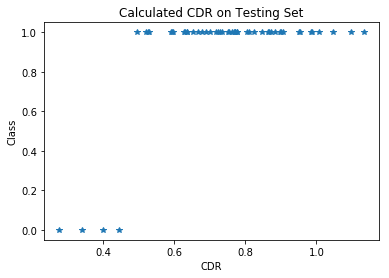

In [26]:
plt.plot(X_test,y_pred,'*')
plt.title("Calculated CDR on Testing Set")
plt.xlabel("CDR")
plt.ylabel("Class")